In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import json
import os
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("WARNING: CUDA not available, using CPU")

print("\n✓ Libraries imported successfully")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
CUDA Version: 12.8
Available GPU Memory: 79.25 GB

✓ Libraries imported successfully


In [51]:
# Data directory
DATA_DIR = '../processed_data'

# Load data
print("Loading data...")
X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val = np.load(f'{DATA_DIR}/X_val.npy')
y_val = np.load(f'{DATA_DIR}/y_val.npy')
X_test = np.load(f'{DATA_DIR}/X_test.npy')
y_test = np.load(f'{DATA_DIR}/y_test.npy')

# Load label mapping
with open(f'{DATA_DIR}/label_mapping.json', 'r') as f:
    label_info = json.load(f)
    label_to_idx = label_info['label_to_idx']
    idx_to_label = {int(k): v for k, v in label_info['idx_to_label'].items()}
    num_classes = label_info['num_classes']

print(f"✓ Data loaded successfully!")
print(f"\nDataset shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test:  {X_test.shape}, y_test: {y_test.shape}")
print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {list(label_to_idx.keys())}")

Loading data...
✓ Data loaded successfully!

Dataset shapes:
  X_train: (44124, 1, 256, 126), y_train: (44124,)
  X_val:   (4903, 1, 256, 126), y_val: (4903,)
  X_test:  (4903, 1, 256, 126), y_test: (4903,)

Number of classes: 4
Class names: ['asthma', 'covid', 'healthy', 'tuberculosis']
✓ Data loaded successfully!

Dataset shapes:
  X_train: (44124, 1, 256, 126), y_train: (44124,)
  X_val:   (4903, 1, 256, 126), y_val: (4903,)
  X_test:  (4903, 1, 256, 126), y_test: (4903,)

Number of classes: 4
Class names: ['asthma', 'covid', 'healthy', 'tuberculosis']


In [52]:
# Convert numpy arrays to PyTorch tensors
print("Converting data to PyTorch tensors...")
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"✓ DataLoaders created successfully!")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


Converting data to PyTorch tensors...
✓ DataLoaders created successfully!
  Batch size: 32
  Train batches: 1379
  Val batches: 154
  Test batches: 154


In [53]:
class CRCNN(nn.Module):
    """
    """
    
    def __init__(self, input_channels=1, num_classes=4, 
                 conv_channels=[64, 128, 256], 
                 rnn_hidden_size=256, rnn_layers=2,
                 dropout=0.5, attention_heads=4):
        super(CRCNN, self).__init__()
        
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.dropout = dropout
        
        # === CONVOLUTIONAL BLOCKS với RESIDUAL CONNECTIONS ===
        self.conv_blocks = nn.ModuleList()
        self.residual_projs = nn.ModuleList()
        
        in_ch = input_channels
        for i, out_ch in enumerate(conv_channels):
            # Main conv path với 2 conv layers
            block = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout * 0.3),  # Dropout thấp hơn cho conv
                
                nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
            )
            self.conv_blocks.append(block)
            
            # Projection cho residual nếu channels thay đổi
            if in_ch != out_ch:
                self.residual_projs.append(
                    nn.Conv2d(in_ch, out_ch, 1, bias=False)
                )
            else:
                self.residual_projs.append(None)
            
            in_ch = out_ch
        
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_2d = nn.Dropout2d(dropout * 0.4)
        
        # Adaptive pooling để đảm bảo kích thước cố định
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 32))  # (1, 32) cho temporal dim
        
        # === FEATURE PROJECTION trước RNN ===
        self.feature_channels = conv_channels[-1]
        self.rnn_hidden_size = rnn_hidden_size
        
        self.pre_rnn_proj = nn.Sequential(
            nn.Linear(self.feature_channels, rnn_hidden_size),
            nn.LayerNorm(rnn_hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.5)
        )
        
        # === BIDIRECTIONAL GRU ===
        self.gru = nn.GRU(
            input_size=rnn_hidden_size,
            hidden_size=rnn_hidden_size,
            num_layers=rnn_layers,
            batch_first=True,
            dropout=dropout * 0.5 if rnn_layers > 1 else 0,
            bidirectional=True
        )
        
        # === MULTI-HEAD ATTENTION ===
        self.attention_heads = attention_heads
        gru_output_size = rnn_hidden_size * 2  # Bidirectional
        
        # Multi-head attention
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(gru_output_size, 64),
                nn.Tanh(),
                nn.Dropout(dropout * 0.3),
                nn.Linear(64, 1)
            ) for _ in range(attention_heads)
        ])
        
        # === CLASSIFICATION HEAD ===
        classifier_input_size = gru_output_size * attention_heads
        
        self.classifier = nn.Sequential(
            # First block
            nn.Linear(classifier_input_size, 512),
            nn.LayerNorm(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            # Second block
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout * 0.6),  # Dropout cao hơn ở cuối
            
            # Output
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Khởi tạo weights tốt hơn"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        nn.init.constant_(param.data, 0)
        
    def forward(self, x):
        """
        Args:
            x: (batch, channels, height, width) - spectrogram
        Returns:
            output: (batch, num_classes) - logits
        """
        # === CONVOLUTIONAL FEATURE EXTRACTION ===
        for i, (conv_block, res_proj) in enumerate(zip(self.conv_blocks, self.residual_projs)):
            identity = x
            
            # Main path
            x = conv_block(x)
            
            # Residual connection
            if res_proj is not None:
                identity = res_proj(identity)
            
            x = x + identity
            x = self.relu(x)
            x = self.pool(x)
            x = self.dropout_2d(x)
        
        # === RESHAPE cho RNN ===
        # Adaptive pooling: (batch, channels, H, W) -> (batch, channels, 1, 32)
        x = self.adaptive_pool(x)
        
        # Reshape: (batch, channels, 1, time) -> (batch, time, channels)
        batch_size, channels, _, time_steps = x.size()
        x = x.squeeze(2).permute(0, 2, 1)  # (batch, time, channels)
        
        # Project features
        x = self.pre_rnn_proj(x)  # (batch, time, rnn_hidden_size)
        
        # === GRU TEMPORAL MODELING ===
        gru_out, _ = self.gru(x)  # (batch, time, rnn_hidden_size * 2)
        
        # === MULTI-HEAD ATTENTION ===
        attended_features = []
        for attention_layer in self.attention_layers:
            # Compute attention weights
            attention_scores = attention_layer(gru_out)  # (batch, time, 1)
            attention_weights = torch.softmax(attention_scores, dim=1)
            
            # Apply attention
            attended = torch.sum(gru_out * attention_weights, dim=1)  # (batch, hidden*2)
            attended_features.append(attended)
        
        # Concatenate all attention heads
        context = torch.cat(attended_features, dim=1)  # (batch, hidden*2*heads)
        
        # === CLASSIFICATION ===
        output = self.classifier(context)
        
        return output
    
    def get_model_size(self):
        """Tính kích thước model"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        return {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'size_mb': total_params * 4 / (1024 ** 2)  # Assuming float32
        }

print("✅ ImprovedCRCNN model defined successfully!")
print("📦 Architecture: Conv(Residual) → GRU(Bidirectional) → Multi-Head Attention → Classifier")
print("🛡️  Anti-overfitting: Dropout 0.5-0.6, BatchNorm, LayerNorm, Residual connections")

✅ ImprovedCRCNN model defined successfully!
📦 Architecture: Conv(Residual) → GRU(Bidirectional) → Multi-Head Attention → Classifier
🛡️  Anti-overfitting: Dropout 0.5-0.6, BatchNorm, LayerNorm, Residual connections


In [54]:
# ============================================
# INITIALIZE MODEL
# ============================================

print("="*80)
print("🚀 INITIALIZING IMPROVED CRCNN MODEL")
print("="*80)

# Get input shape
input_channels = X_train_tensor.shape[1]  # Should be 1 for grayscale spectrograms

# Create model với best hyperparameters
model = CRCNN(
    input_channels=input_channels,
    num_classes=num_classes,
    conv_channels=[64, 128, 256],    # Progressive feature extraction
    rnn_hidden_size=256,             # GRU hidden size
    rnn_layers=2,                    # 2-layer bidirectional GRU
    dropout=0.5,                     # Strong dropout for anti-overfitting
    attention_heads=4                # Multi-head attention
).to(device)

# Model information
model_info = model.get_model_size()
print(f"\n📊 Model Information:")
print(f"  Total parameters: {model_info['total_params']:,}")
print(f"  Trainable parameters: {model_info['trainable_params']:,}")
print(f"  Model size: {model_info['size_mb']:.2f} MB")
print(f"  Input channels: {input_channels}")
print(f"  Output classes: {num_classes}")

# Test forward pass
print(f"\n🧪 Testing model forward pass...")
model.eval()
with torch.no_grad():
    sample_input = X_train_tensor[:2].to(device)
    sample_output = model(sample_input)
    
print(f"  Input shape: {sample_input.shape}")
print(f"  Output shape: {sample_output.shape}")
print(f"  Output range: [{sample_output.min():.3f}, {sample_output.max():.3f}]")
print(f"✅ Model initialized successfully!")

model.train()
print("="*80)

🚀 INITIALIZING IMPROVED CRCNN MODEL

📊 Model Information:
  Total parameters: 4,539,272
  Trainable parameters: 4,539,272
  Model size: 17.32 MB
  Input channels: 1
  Output classes: 4

🧪 Testing model forward pass...
  Input shape: torch.Size([2, 1, 256, 126])
  Output shape: torch.Size([2, 4])
  Output range: [-0.864, 0.204]
✅ Model initialized successfully!


In [55]:
# ============================================
# TRAINING CONFIGURATION - OPTIMIZED FOR HIGH ACCURACY & ANTI-OVERFITTING
# ============================================

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("📊 Class Distribution:")
for i, (label, weight) in enumerate(zip(idx_to_label.values(), class_weights)):
    count = np.sum(y_train == i)
    print(f"  Class {i} ({label}): {count} samples, weight={weight:.3f}")

# Loss function với class weights và label smoothing
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor, 
    label_smoothing=0.1  # Label smoothing to prevent overconfidence
)

# Optimizer: AdamW với weight decay
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.001,              # Initial learning rate
    weight_decay=0.01,     # Weight decay for L2 regularization
    betas=(0.9, 0.999),
)

# Learning rate scheduler: ReduceLROnPlateau
# NOTE: some PyTorch versions removed the `verbose` kwarg -> remove it to avoid TypeError
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # Maximize validation accuracy
    factor=0.5,           # Reduce LR by half
    patience=5,           # Wait 5 epochs before reducing
    min_lr=1e-6,
)

print("\n⚙️  TRAINING CONFIGURATION:")
print(f"  Loss: CrossEntropyLoss (class-weighted, label_smoothing=0.1)")
print(f"  Optimizer: AdamW (lr=0.001, weight_decay=0.01)")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")
print(f"  Batch size: {batch_size}")
print(f"  Gradient clipping: 1.0")
print(f"\n🛡️  ANTI-OVERFITTING STRATEGIES:")
print(f"  ✅ Dropout: 0.5-0.6 in model")
print(f"  ✅ Weight Decay: 0.01")
print(f"  ✅ Label Smoothing: 0.1")
print(f"  ✅ SpecAugment: Time & Freq masking")
print(f"  ✅ Class-balanced loss")
print(f"  ✅ Early stopping (patience=10)")
print(f"  ✅ Gradient clipping")


📊 Class Distribution:
  Class 0 (asthma): 8304 samples, weight=1.328
  Class 1 (covid): 14709 samples, weight=0.750
  Class 2 (healthy): 6399 samples, weight=1.724
  Class 3 (tuberculosis): 14712 samples, weight=0.750

⚙️  TRAINING CONFIGURATION:
  Loss: CrossEntropyLoss (class-weighted, label_smoothing=0.1)
  Optimizer: AdamW (lr=0.001, weight_decay=0.01)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
  Batch size: 32
  Gradient clipping: 1.0

🛡️  ANTI-OVERFITTING STRATEGIES:
  ✅ Dropout: 0.5-0.6 in model
  ✅ Weight Decay: 0.01
  ✅ Label Smoothing: 0.1
  ✅ SpecAugment: Time & Freq masking
  ✅ Class-balanced loss
  ✅ Early stopping (patience=10)
  ✅ Gradient clipping


In [56]:
# ============================================
# TRAINING LOOP với Early Stopping
# ============================================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=80, early_stopping_patience=10, 
                save_path='best_crcnn_cough.pth'):
    """
    Complete training loop với monitoring và early stopping
    """
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    
    print("\n" + "="*80)
    print("🎓 STARTING TRAINING")
    print("="*80)
    print(f"Device: {device}")
    print(f"Total epochs: {num_epochs}")
    print(f"Early stopping patience: {early_stopping_patience}")
    print(f"Model checkpoints will be saved to: {save_path}")
    print("="*80 + "\n")
    
    for epoch in range(num_epochs):
        epoch_start_time = datetime.now()
        
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print("-" * 40)
        
        # Training phase
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, 
            augmentation=augmentation
        )
        
        # Validation phase
        val_loss, val_acc, val_preds, val_targets = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Update learning rate
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)
        
        # Print epoch summary
        epoch_time = (datetime.now() - epoch_start_time).total_seconds()
        train_val_gap = train_acc - val_acc
        
        print(f"\n📊 Results:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"  Train-Val Gap: {train_val_gap:+.2f}%")
        print(f"  Learning Rate: {current_lr:.2e}")
        print(f"  Epoch Time: {epoch_time:.1f}s")
        
        # Check for overfitting warning
        if train_val_gap > 10:
            print(f"  ⚠️  Warning: Possible overfitting (gap > 10%)")
        
        # Save best model
        if val_acc > best_val_acc:
            improvement = val_acc - best_val_acc
            best_val_acc = val_acc
            
            # Save checkpoint
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
                'history': history,
                'class_names': list(idx_to_label.values())
            }
            torch.save(checkpoint, save_path)
            
            print(f"  ✅ New best model saved! (+{improvement:.2f}% improvement)")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  No improvement ({patience_counter}/{early_stopping_patience})")
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\n{'='*80}")
            print(f"⏹️  Early stopping triggered!")
            print(f"   Best validation accuracy: {best_val_acc:.2f}%")
            print(f"   Stopping at epoch {epoch+1}")
            print("="*80)
            break
        
        print("")  # Empty line for readability
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETED!")
    print("="*80)
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Total epochs trained: {len(history['train_loss'])}")
    print(f"Model saved to: {save_path}")
    print("="*80 + "\n")
    
    return history, best_val_acc

print("✅ Training loop function defined!")

✅ Training loop function defined!


In [57]:
# === Data Augmentation: SpecAugment (time & frequency masking) ===
import random

def spec_augment_tensor(spectrogram, num_time_masks=2, time_mask_max_pct=0.1,
                        num_freq_masks=2, freq_mask_max_pct=0.15):
    """Apply SpecAugment to a single spectrogram tensor.
    Args:
        spectrogram: Tensor shape (C, H, W) or (channels, freq, time)
    Returns:
        augmented spectrogram tensor
    """
    aug = spectrogram.clone()
    # assume shape (C, F, T) or (F, T) if single channel
    if aug.dim() == 3:
        _, freq_size, time_size = aug.shape
    elif aug.dim() == 2:
        freq_size, time_size = aug.shape
    else:
        # unexpected shape
        return aug

    # Frequency masking
    for _ in range(num_freq_masks):
        f = int(random.uniform(0.0, freq_mask_max_pct) * freq_size)
        if f == 0:
            continue
        f0 = random.randint(0, max(0, freq_size - f))
        if aug.dim() == 3:
            aug[:, f0:f0+f, :] = 0
        else:
            aug[f0:f0+f, :] = 0

    # Time masking
    for _ in range(num_time_masks):
        t = int(random.uniform(0.0, time_mask_max_pct) * time_size)
        if t == 0:
            continue
        t0 = random.randint(0, max(0, time_size - t))
        if aug.dim() == 3:
            aug[:, :, t0:t0+t] = 0
        else:
            aug[:, t0:t0+t] = 0

    return aug


def augmentation_batch(batch_inputs, prob=0.8):
    """Apply augmentation to a batch of spectrograms with given probability."""
    # batch_inputs: (B, C, F, T)
    if random.random() > prob:
        return batch_inputs
    aug_batch = batch_inputs.clone()
    for i in range(aug_batch.size(0)):
        aug_batch[i] = spec_augment_tensor(aug_batch[i])
    return aug_batch

# Set the augmentation callable to pass into train_epoch
augmentation = augmentation_batch

print("✓ SpecAugment augmentation ready (applied with probability ~0.8)")

✓ SpecAugment augmentation ready (applied with probability ~0.8)


In [58]:
# ============================================
# TRAINING & VALIDATION FUNCTIONS WITH AUGMENTATION SUPPORT
# ============================================

def train_epoch(model, train_loader, criterion, optimizer, device, augmentation=None):
    """Train for one epoch with optional augmentation"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc="Training", leave=False)
    for inputs, targets in train_bar:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        
        # Apply augmentation if provided
        if augmentation is not None:
            inputs = augmentation(inputs)
        
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        train_bar.set_postfix({
            'Loss': f'{running_loss/(train_bar.n+1):.3f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        for inputs, targets in val_bar:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Save for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Update progress bar
            val_bar.set_postfix({
                'Loss': f'{val_loss/(val_bar.n+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = val_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

print("✅ Training and validation functions defined successfully!")
print("   - Supports SpecAugment augmentation during training")
print("   - Includes gradient clipping (max_norm=1.0)")
print("   - Progress bars with real-time metrics")

✅ Training and validation functions defined successfully!
   - Supports SpecAugment augmentation during training
   - Includes gradient clipping (max_norm=1.0)
   - Progress bars with real-time metrics


In [ ]:
# ============================================
# SET TRAINING HYPERPARAMETERS
# ============================================

num_epochs = 80  # Maximum number of epochs
patience = 10    # Early stopping patience

print("📋 Training Hyperparameters:")
print(f"  Max epochs: {num_epochs}")
print(f"  Early stopping patience: {patience}")
print(f"  Model will stop if no improvement for {patience} consecutive epochs")
print("="*60)

In [59]:
# Training Loop with Early Stopping
print("Starting training...")
print("=" * 60)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

# Early stopping variables
best_val_loss = float('inf')
best_val_acc = 0.0
epochs_no_improve = 0
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)
    
    # Train (apply augmentation)
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, augmentation=augmentation)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate (monitoring validation accuracy)
    # ReduceLROnPlateau was configured with mode='max' so pass val_acc
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    # Print epoch summary
    print(f"\nEpoch Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")
    
    # Check for best model (using validation accuracy to reduce overfitting risk)
    if val_acc > best_val_acc:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        epochs_no_improve = 0
        print(f"  ✓ New best model! Val Loss: {best_val_loss:.4f}, Val Acc: {best_val_acc:.2f}%")
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            'val_acc': best_val_acc,
        }, 'best_crcnn_model.pth')
    else:
        epochs_no_improve += 1
        print(f"  No improvement for {epochs_no_improve} epoch(s)")
        
        # Early stopping
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            print(f"Best Val Loss: {best_val_loss:.4f}, Best Val Acc: {best_val_acc:.2f}%")
            break

print("\n" + "=" * 60)
print("Training completed!")
print(f"Best Val Loss: {best_val_loss:.4f}")
print(f"Best Val Acc: {best_val_acc:.2f}%")
print("=" * 60)

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("\n✓ Best model loaded for evaluation")

Starting training...

Epoch 1/50
------------------------------------------------------------



Epoch Summary:
  Train Loss: 1.4300 | Train Acc: 22.93%
  Val Loss:   1.4071 | Val Acc:   33.35%
  Learning Rate: 0.001000
  ✓ New best model! Val Loss: 1.4071, Val Acc: 33.35%

Epoch 2/50
------------------------------------------------------------



Epoch Summary:
  Train Loss: 1.4090 | Train Acc: 21.63%
  Val Loss:   1.4059 | Val Acc:   18.80%
  Learning Rate: 0.001000
  No improvement for 1 epoch(s)

Epoch 3/50
------------------------------------------------------------



Epoch Summary:
  Train Loss: 1.4072 | Train Acc: 20.07%
  Val Loss:   1.4062 | Val Acc:   33.35%
  Learning Rate: 0.001000
  No improvement for 2 epoch(s)

Epoch 4/50
------------------------------------------------------------



Epoch Summary:
  Train Loss: 1.4064 | Train Acc: 18.48%
  Val Loss:   1.4068 | Val Acc:   18.80%
  Learning Rate: 0.001000
  No improvement for 3 epoch(s)

Epoch 5/50
------------------------------------------------------------



Epoch Summary:
  Train Loss: 1.4062 | Train Acc: 16.20%
  Val Loss:   1.4058 | Val Acc:   14.50%
  Learning Rate: 0.001000
  No improvement for 4 epoch(s)

Epoch 6/50
------------------------------------------------------------



Epoch Summary:
  Train Loss: 1.4061 | Train Acc: 15.66%
  Val Loss:   1.4056 | Val Acc:   14.50%
  Learning Rate: 0.001000
  No improvement for 5 epoch(s)

Epoch 7/50
------------------------------------------------------------


KeyboardInterrupt: 

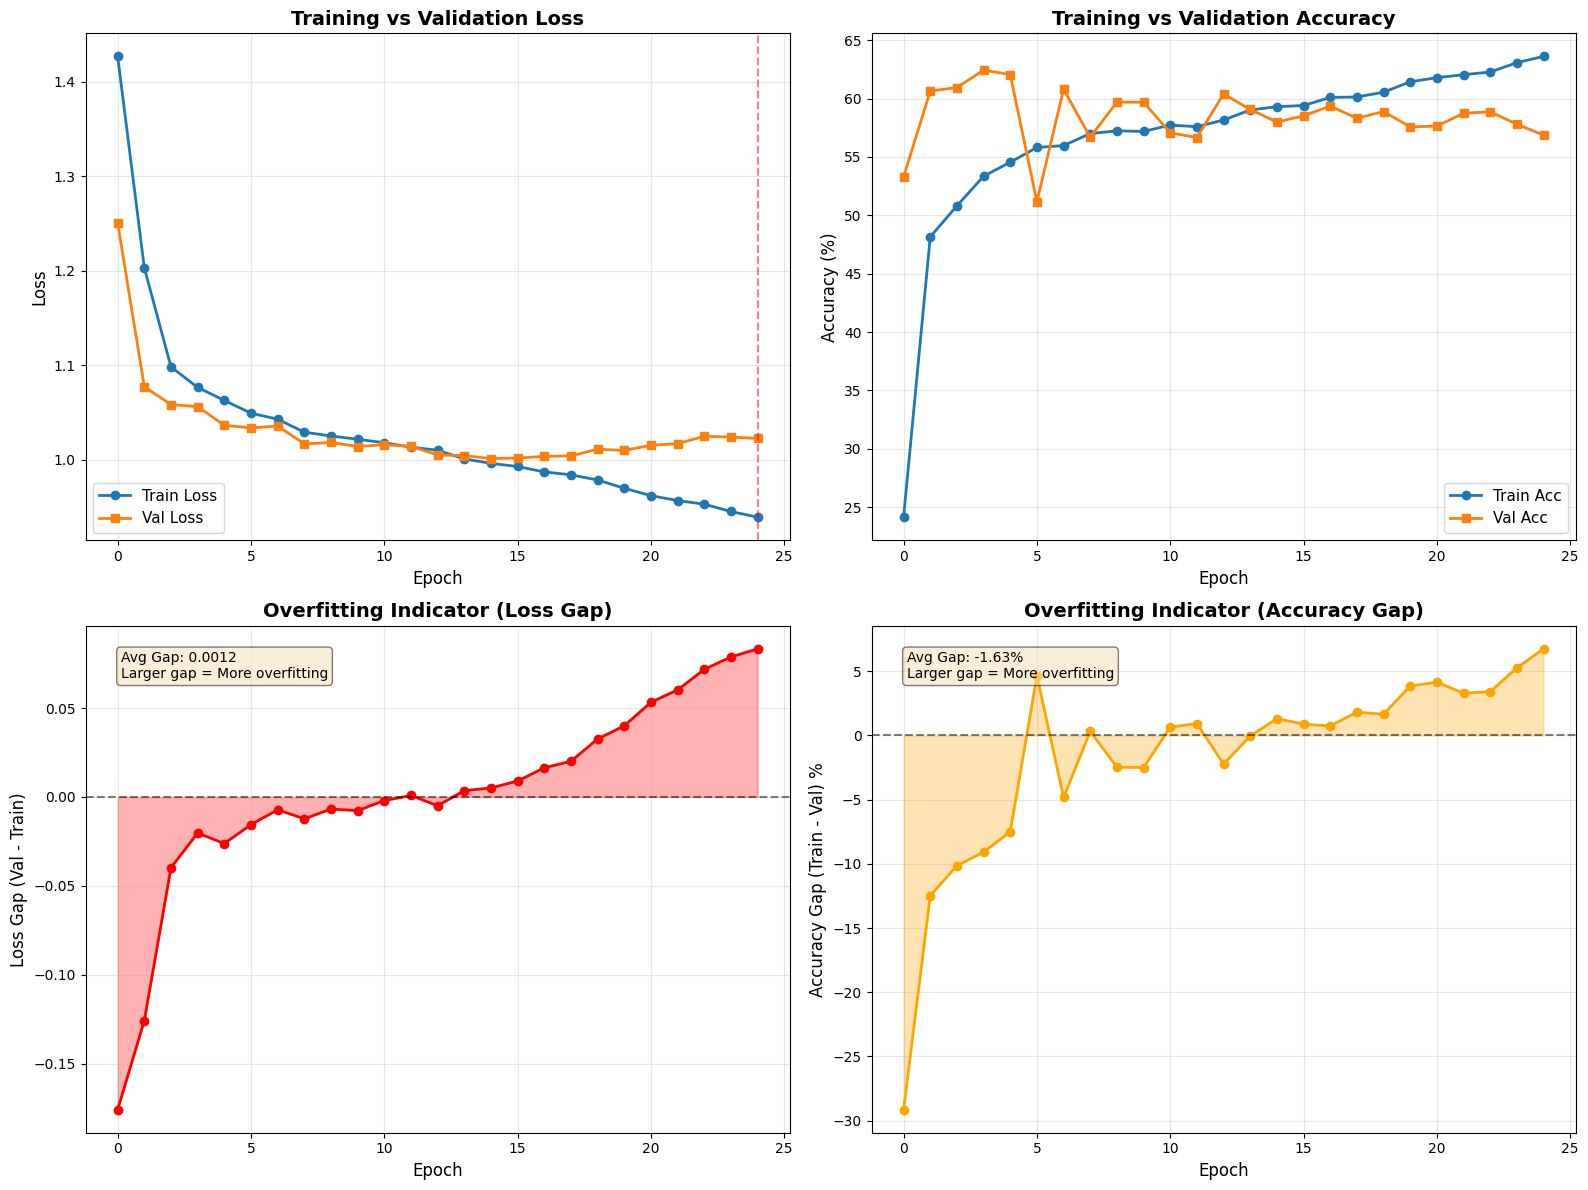

OVERFITTING ANALYSIS

Loss Analysis:
  Final Train Loss: 0.9394
  Final Val Loss:   1.0227
  Loss Gap:         0.0833
  Average Loss Gap: 0.0012

Accuracy Analysis:
  Final Train Acc:  63.61%
  Final Val Acc:    56.86%
  Accuracy Gap:     6.75%
  Average Acc Gap:  -1.63%

Overfitting Assessment:
  ✓ Model shows GOOD generalization (minimal overfitting)
✓ Training history with overfitting analysis saved as 'training_history_overfitting_analysis.png'


In [ ]:
# Visualize Training History to Detect Overfitting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Loss comparison
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Add gap indicator for overfitting
gap = np.array(history['val_loss']) - np.array(history['train_loss'])
max_gap_idx = np.argmax(gap)
axes[0, 0].axvline(x=max_gap_idx, color='red', linestyle='--', alpha=0.5, label=f'Max Gap at Epoch {max_gap_idx+1}')

# Plot 2: Accuracy comparison
axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Overfitting Gap (Val Loss - Train Loss)
loss_gap = np.array(history['val_loss']) - np.array(history['train_loss'])
axes[1, 0].plot(loss_gap, marker='o', color='red', linewidth=2)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].fill_between(range(len(loss_gap)), loss_gap, 0, alpha=0.3, color='red')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss Gap (Val - Train)', fontsize=12)
axes[1, 0].set_title('Overfitting Indicator (Loss Gap)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Add interpretation text
avg_gap = np.mean(loss_gap)
axes[1, 0].text(0.05, 0.95, f'Avg Gap: {avg_gap:.4f}\nLarger gap = More overfitting', 
                transform=axes[1, 0].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 4: Accuracy Gap (Train Acc - Val Acc)
acc_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
axes[1, 1].plot(acc_gap, marker='o', color='orange', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].fill_between(range(len(acc_gap)), acc_gap, 0, alpha=0.3, color='orange')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy Gap (Train - Val) %', fontsize=12)
axes[1, 1].set_title('Overfitting Indicator (Accuracy Gap)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Add interpretation text
avg_acc_gap = np.mean(acc_gap)
axes[1, 1].text(0.05, 0.95, f'Avg Gap: {avg_acc_gap:.2f}%\nLarger gap = More overfitting', 
                transform=axes[1, 1].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('training_history_overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print overfitting analysis
print("=" * 60)
print("OVERFITTING ANALYSIS")
print("=" * 60)
print(f"\nLoss Analysis:")
print(f"  Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"  Final Val Loss:   {history['val_loss'][-1]:.4f}")
print(f"  Loss Gap:         {loss_gap[-1]:.4f}")
print(f"  Average Loss Gap: {avg_gap:.4f}")

print(f"\nAccuracy Analysis:")
print(f"  Final Train Acc:  {history['train_acc'][-1]:.2f}%")
print(f"  Final Val Acc:    {history['val_acc'][-1]:.2f}%")
print(f"  Accuracy Gap:     {acc_gap[-1]:.2f}%")
print(f"  Average Acc Gap:  {avg_acc_gap:.2f}%")

# Overfitting interpretation
print(f"\nOverfitting Assessment:")
if avg_gap < 0.1 and avg_acc_gap < 5:
    print("  ✓ Model shows GOOD generalization (minimal overfitting)")
elif avg_gap < 0.2 and avg_acc_gap < 10:
    print("  ⚠ Model shows MODERATE overfitting (acceptable)")
else:
    print("  ✗ Model shows SIGNIFICANT overfitting (needs attention)")
    print("    Consider: more dropout, data augmentation, or regularization")

print("=" * 60)
print("✓ Training history with overfitting analysis saved as 'training_history_overfitting_analysis.png'")


In [ ]:
# Evaluate on Test Set
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

print("Evaluating on test set...")
y_pred, y_true = evaluate_model(model, test_loader, device)

# Calculate metrics
test_accuracy = accuracy_score(y_true, y_pred)

print("\n" + "=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(label_to_idx.keys())))
print("=" * 60)

Evaluating on test set...


Evaluating: 100%|██████████| 154/154 [00:02<00:00, 62.33it/s]


TEST SET RESULTS
Test Accuracy: 57.54%

Classification Report:
              precision    recall  f1-score   support

      asthma       0.31      0.43      0.36       923
       covid       0.65      0.23      0.34      1634
     healthy       0.31      0.60      0.41       712
tuberculosis       0.98      0.99      0.99      1634

    accuracy                           0.58      4903
   macro avg       0.56      0.56      0.52      4903
weighted avg       0.65      0.58      0.57      4903



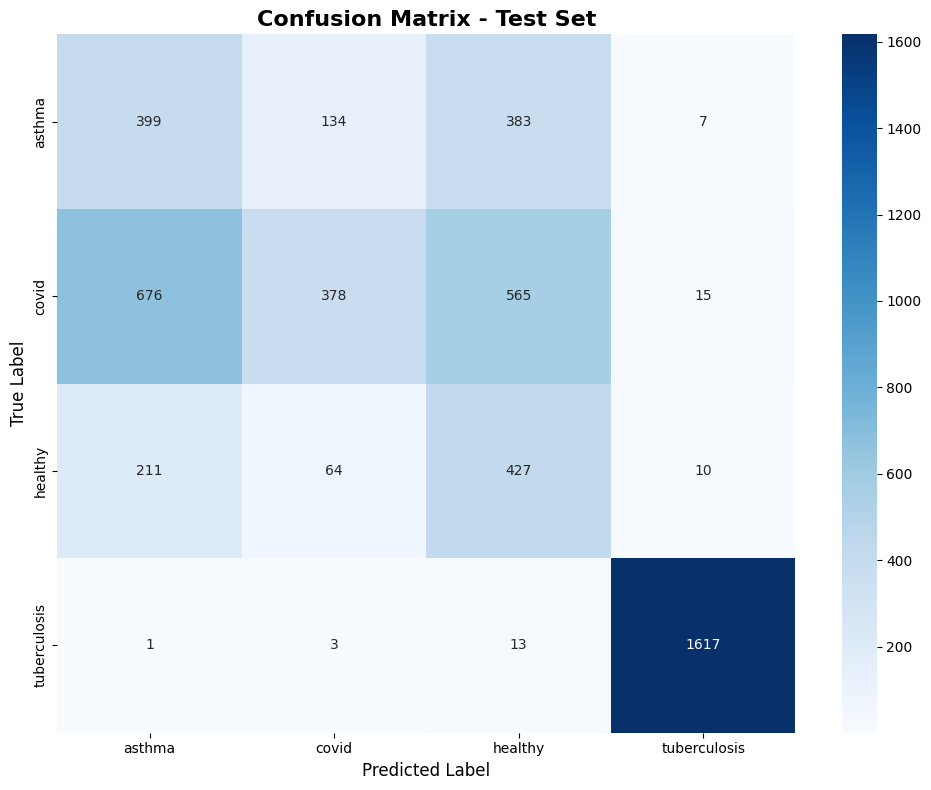

✓ Confusion matrix saved as 'confusion_matrix.png'


In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_to_idx.keys()),
            yticklabels=list(label_to_idx.keys()))
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix.png'")

In [ ]:
# Save Final Model and Training Info
final_model_path = 'crcnn_final_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': num_classes,
    'label_to_idx': label_to_idx,
    'idx_to_label': idx_to_label,
    'test_accuracy': test_accuracy,
    'history': history,
    'model_config': {
        'input_channels': 3,
        'cnn_dropout': 0.3,
        'rnn_dropout': 0.3,
    }
}, final_model_path)

print("=" * 60)
print("MODEL SAVED")
print("=" * 60)
print(f"Final model saved to: {final_model_path}")
print(f"Best model saved to: best_crcnn_model.pth")
print(f"\nFinal Test Accuracy: {test_accuracy * 100:.2f}%")
print("=" * 60)

# Print summary
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Model: CRCNN (Convolutional Recurrent Neural Network)")
print(f"Dataset: Cough Detection Spectrograms")
print(f"Classes: {num_classes} ({', '.join(list(label_to_idx.keys()))})")
print(f"Total Parameters: {total_params:,}")
print(f"Training Samples: {len(train_loader.dataset)}")
print(f"Validation Samples: {len(val_loader.dataset)}")
print(f"Test Samples: {len(test_loader.dataset)}")
print(f"Epochs Trained: {len(history['train_loss'])}")
print(f"Best Val Accuracy: {best_val_acc:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print("=" * 60)

MODEL SAVED
Final model saved to: crcnn_final_model.pth
Best model saved to: best_crcnn_model.pth

Final Test Accuracy: 57.54%

TRAINING SUMMARY
Model: CRCNN (Convolutional Recurrent Neural Network)
Dataset: Cough Detection Spectrograms
Classes: 4 (asthma, covid, healthy, tuberculosis)
Total Parameters: 7,975,492
Training Samples: 44124
Validation Samples: 4903
Test Samples: 4903
Epochs Trained: 25
Best Val Accuracy: 57.98%
Final Test Accuracy: 57.54%
